# Data Preprocessing Experiments

In [1]:
import os
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 100
from torch.utils.data import Dataset, DataLoader
import warnings
import pandas as pd
from skimage.restoration import denoise_wavelet
import csv
import codecs
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import scipy.signal as signal
warnings.filterwarnings('ignore')

In [2]:
path = '../NeuroscienceSeniorResearch/grabmyo/1.0.0/Session1/session1_participant1/session1_participant1_gesture1_trial1.dat'
text = np.fromfile(path, dtype="byte").astype(float)
data = text.reshape((20480, 32))[:10240, :].T

In [3]:
def denoise_seqs_linear_filtering(data, plot=False, ch=0, plot_start=0, plot_end=-1):
    N = 3
    Wn = 0.1
    data /= np.amax(data)
    B, A = signal.butter(N, Wn, output='ba')
    denoised_data = []
    for i in range(32):
        denoised_data.append(signal.filtfilt(B,A, data[i, :]))
    denoised_data = np.array(denoised_data)
    if plot:
        plt.xlabel('Time Stamp')
        plt.ylabel('Frequency')
        plt.title('Linear Filtering, Channel: ' + str(ch))
        plt.plot(data[ch, plot_start:plot_end], 'r-')
        plt.plot(denoised_data[ch, plot_start:plot_end], 'b-')
        plt.show()
    denoised_data /= np.amax(denoised_data)
    return denoised_data

def denoise_seqs_wavelet_transform(data, plot=False, ch=0, plot_start=0, plot_end=-1):
    data /= np.amax(data)
    denoised_data = denoise_wavelet(data, method='BayesShrink', mode='soft', wavelet_levels=5, wavelet='sym8', rescale_sigma='True')
    if plot:
        plt.plot(data[ch, plot_start:plot_end], 'r-')
        plt.plot(denoised_data[ch, plot_start:plot_end], 'b-')
        plt.title('Wavelet Transform, Channel: ' + str(ch))
        plt.xlabel('Time Stamp')
        plt.ylabel('Frequency')
        plt.show()
    denoised_data /= np.amax(denoised_data)
    return denoised_data

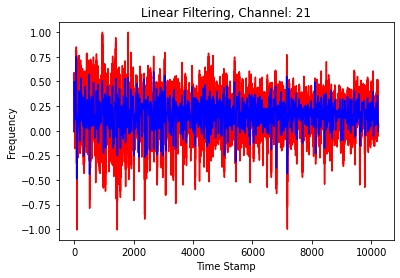

In [4]:
denoised_full_signal = denoise_seqs_linear_filtering(data, True, 21)

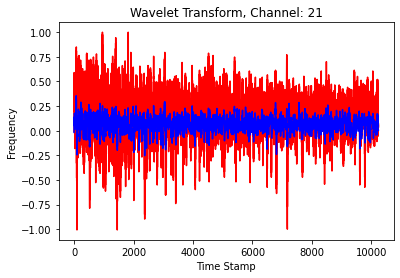

In [5]:
denoised_full_signal = denoise_seqs_wavelet_transform(data, True, 21)

# Data Loading

In [6]:
# filename = "grabmyo/1.0.0"
# Session = ['Session1', 'Session2', 'Session3']

# everything1, everything2, everything3, everything4 = [], [], [], []

# for i in Session:
#     f = filename + "/" + i
#     for j in tqdm(range(1,44),desc = "Participants in " + i):
#         fi = f + "/" + i.lower() + "_participant" + str(j)
#         for k in [11,12,15,16]:
#             fin = fi + "/" + i.lower() + "_participant" + str(j) + "_gesture" + str(k)
#             for l in range(1,8):
#                 fina = fin + "_trial" + str(l) + ".dat"
#                 data = np.fromfile(fina, dtype = 'byte')
#                 data = data.reshape((20480,32))
#                 if k==11: everything1.append(data)
#                 if k==12: everything2.append(data)
#                 if k==15: everything3.append(data)
#                 if k==16: everything4.append(data)
    
# np.save("WristFlexion", np.array(everything1))
# np.save("WristExtension", np.array(everything2))
# np.save("HandOpen", np.array(everything3))
# np.save("HandClose", np.array(everything4))

# Dataset

In [7]:
# filenames = ['HandClose', 'HandOpen', 'WristExtension', 'WristFlexion']
# hand_close_data = np.load('HandClose.npy')
# hand_open_data = np.load('HandOpen.npy')
# wrist_extension_data = np.load('WristExtension.npy')
# wrist_flexion_data = np.load('WristFlexion.npy')

# for gesture_num, gesture in enumerate([hand_close_data, hand_open_data, wrist_extension_data, wrist_flexion_data]):
#     emgs = []
#     for i in range(gesture.shape[0]):
#         current_emg = gesture[i].astype('float32')
#         current_emg /= np.amax(current_emg)
#         current_emg = denoise_seqs_wavelet_transform(current_emg)
#         emgs.append(current_emg[:, :].T)
#     np.save(filenames[gesture_num]+'Processed', np.array(emgs))

In [8]:
# for gesture_num, gesture in enumerate([hand_close_data, hand_open_data, wrist_extension_data, wrist_flexion_data]):
#     emgs = []
#     for i in range(gesture.shape[0]):
#         current_emg = gesture[i].astype('float32')
#         current_emg /= np.amax(current_emg)
#         current_emg = denoise_seqs_wavelet_transform(current_emg)
#         emgs.append(current_emg)
#     np.save(filenames[gesture_num]+'Processed', np.array(emgs))

In [9]:
class GestureDataset(torch.utils.data.Dataset):
    def __init__(self, timechunk=20480):
        super().__init__()
        assert 20480%timechunk == 0
        self.hand_close_data = np.load('HandCloseProcessed.npy')
        self.hand_open_data = np.load('HandOpenProcessed.npy')
        self.wrist_extension_data = np.load('WristExtensionProcessed.npy')
        self.wrist_flexion_data = np.load('WristFlexionProcessed.npy')

        self.emgs = []
        self.labels = []
        
        for gesture_num, gesture in enumerate([self.hand_close_data, self.hand_open_data, self.wrist_extension_data, self.wrist_flexion_data]):
            for i in range(gesture.shape[0]):
                current_emg = gesture[i]
                current_timestep = 0
                while current_timestep != 20480:
                    self.emgs.append(gesture[i, current_timestep:current_timestep+timechunk, :].T)
                    self.labels.append([gesture_num])
#                     self.labels[-1][gesture_num] = 1
                    current_timestep += timechunk
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.Tensor(self.emgs[idx]), torch.Tensor(self.labels[idx])

# Model Creation + Training

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# class big_network(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(32, 64, kernel_size=25)
#         self.conv2 = nn.Conv1d(64, 128, kernel_size=15)
#         self.conv3 = nn.Conv1d(128, 256, kernel_size=10)
#         self.flat = nn.Flatten()
#         self.lin1 = nn.Linear(653824, 8192)
#         self.lin2 = nn.Linear(8192, 2048)
#         self.lin3 = nn.Linear(2048, 128)
#         self.lin4 = nn.Linear(128, 32)
#         self.lin5 = nn.Linear(32, 5)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.flat(x)
#         x = self.lin1(x)
#         x = self.lin2(x)
#         x = self.lin3(x)
#         x = self.lin4(x)
#         x = self.lin5(x)
#         return x

class small_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(32, 64, kernel_size=25)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=15)
        self.flat = nn.Flatten()
#         self.lin1 = nn.Linear(1305856, 8192)
        self.lin2 = nn.Linear(1305856, 2048)
        self.lin3 = nn.Linear(2048, 128)
        self.lin4 = nn.Linear(128, 32)
        self.lin5 = nn.Linear(32, 5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flat(x)
#         x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        x = self.lin5(x)
        return x
    
class CNN(nn.Module):
    def __init__(self, timechunk=20480):
        super().__init__()
        self.conv1 = nn.Conv1d(32, 64, kernel_size=15)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=15)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=15)
        self.maxpool = nn.MaxPool1d(4)
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(15104, 256)
        self.lin2 = nn.Linear(256, 32)
        self.lin3 = nn.Linear(32, 4)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

In [11]:
BATCH_SIZE = 1
SHUFFLE = True
NUM_WORKERS = 1
TIMECHUNK_SIZE = 4096
LEARNING_RATE = 0.001
EPOCHS = 2
DEVICE = 'cuda'
DEBUG = False


total_dataset = GestureDataset(TIMECHUNK_SIZE)
train_valid_size, test_size = int(0.8 * len(total_dataset)), len(total_dataset) - int(0.8 * len(total_dataset))
train_valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_valid_size, test_size])
train_size, valid_size = int(0.8 * len(train_valid_dataset)), len(train_valid_dataset) - int(0.8 * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
model = CNN(TIMECHUNK_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
def train(model, epochs, train_dataloader, valid_dataloader, optimizer, criterion, device='cuda', debug=False):
    model = model.to(device)
    training_loss_list = []
    validation_loss_list = []
    
    for epoch in range(1, epochs+1):
        # Training
        model.train()
        total_loss = 0.
        num_X = 0
        for ind, (X, y) in enumerate(tqdm(train_dataloader)):
            X = X.to(device)
            
            optimizer.zero_grad()
            y_hat = model(X)
            if debug: print(criterion(y_hat, torch.max(y, dim=1)[0].to(torch.long).to(device)).item())            
            loss = criterion(y_hat, torch.max(y, dim=1)[0].to(torch.long).to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_X += 1
        training_loss_list.append(total_loss/num_X)
        print(f"Epoch #{epoch}, Training Loss: {total_loss/num_X:.5f}")
        
        # Validation
        model.eval()
        total_loss = 0.
        num_X = 0
        for ind, (X, y) in enumerate(tqdm(valid_dataloader)):
            X = X.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                y_hat = model(X)
            
            total_loss += criterion(y_hat, torch.max(y, dim=1)[0].to(torch.long).to(device))
            num_X += 1
        validation_loss_list.append(total_loss/num_X)
        print(f"Epoch #{epoch}, Validation Loss: {total_loss/num_X:.5f}")
        print("-"*40)
    
    return model, training_loss_list, validation_loss_list

In [8]:
trained_model, train_losses, val_losses = train(model, EPOCHS, valid_loader, test_loader, optimizer, criterion, device=DEVICE, debug=DEBUG)

RuntimeError: cuda runtime error (804) : forward compatibility was attempted on non supported HW at /tmp/pip-req-build-8yht7tdu/aten/src/THC/THCGeneral.cpp:50

In [44]:
def plot_training_results(epochs, train_loss_values, valid_loss_values):
    mpl.rcParams['figure.dpi'] = 500
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss during training')
    ax.plot(list(range(1, epochs+1)), train_loss_values, '-b', label='Train loss')
    ax.plot(list(range(1, epochs+1)), valid_loss_values, '-r', label='Valid loss')
    leg = ax.legend(frameon=False);

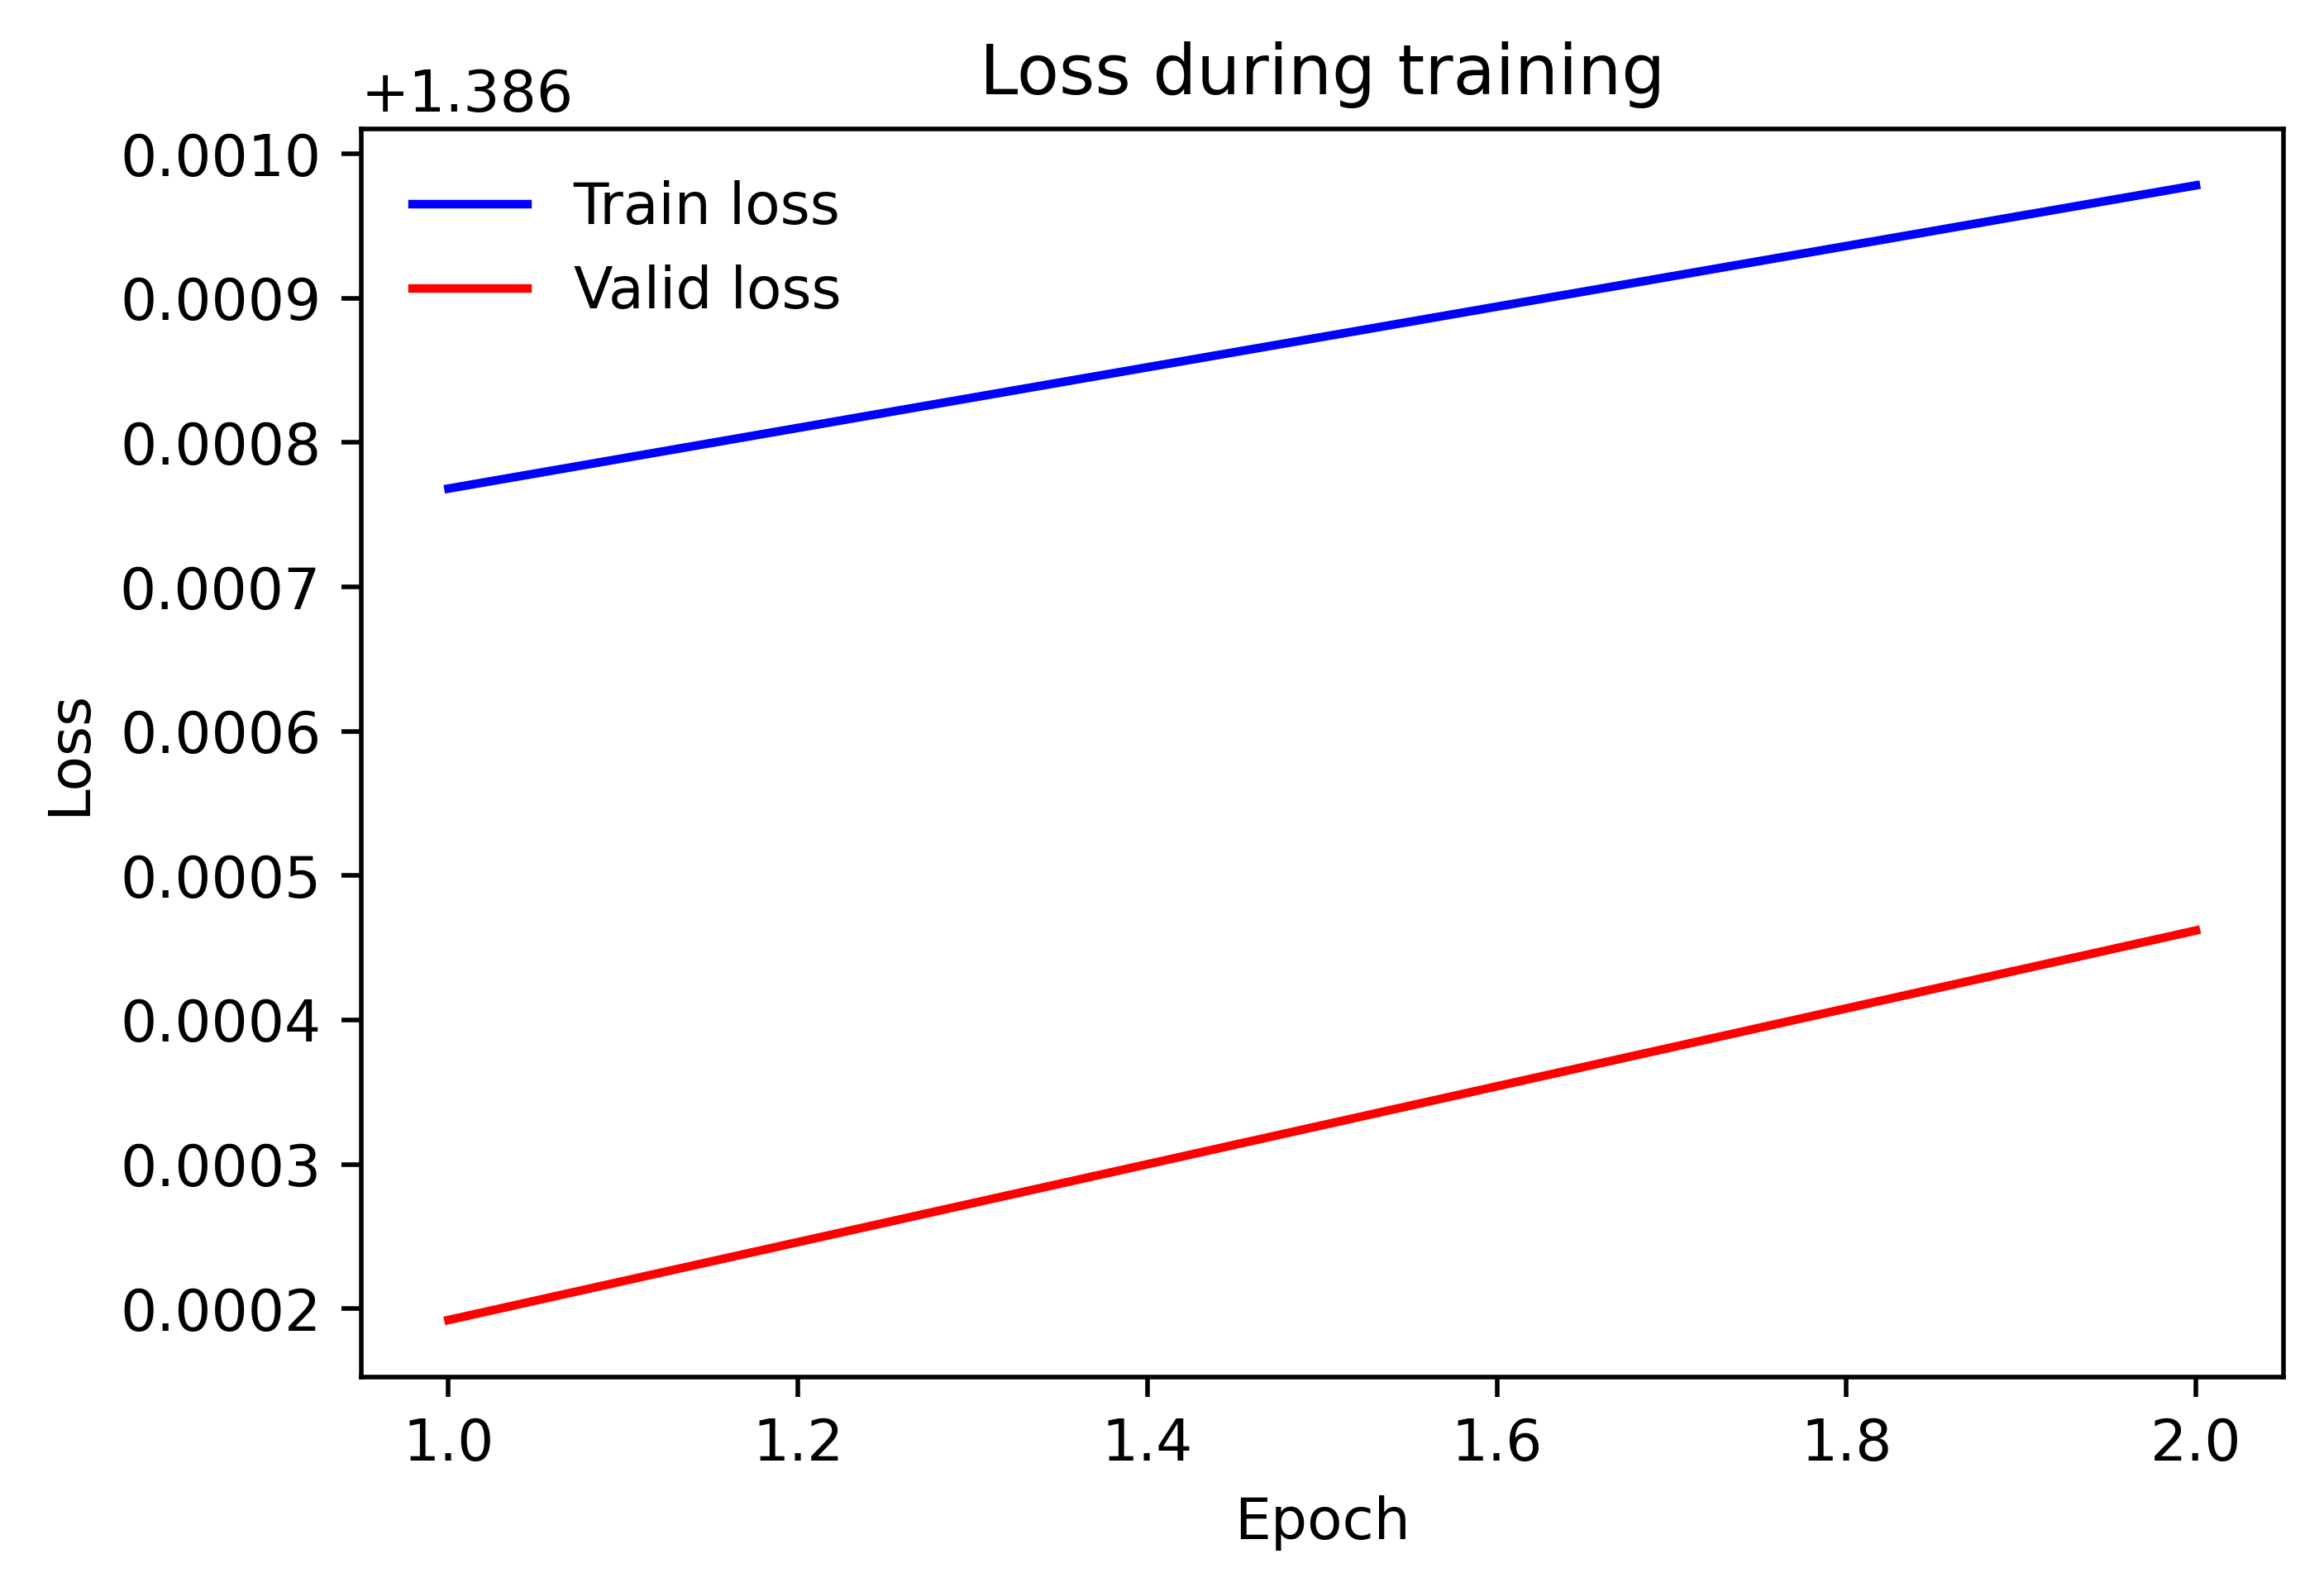

In [45]:
plot_training_results(EPOCHS, train_losses, val_losses)

In [48]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test EMGs: {100 * correct // total}%')

Accuracy of the network on the test EMGs: 24%
